# Practical Lab 7 - Performance Metrics for Classification

## Introduction

The goal is to develop a model to recognize/classify digits of MNIST dataset. We are going to use MNIST dataset which consists of 70,000 images of numbers from 0 to 9. The images are represented as pixels. There are around 784 features representing the pixel values. Each image corresponds to a pixel array of 28X28. 

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
import plotly.express as px
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches
from sklearn.metrics import accuracy_score,confusion_matrix,precision_recall_fscore_support, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score

In [113]:
# Fetching the MNIST dataset from openml
mnist = fetch_openml('mnist_784', as_frame=True, parser='auto')

In [114]:
# Converting it to a dataframe
df_mnist_dataset = mnist.data


In [115]:
# Appending the Target column to the input features
df_mnist_dataset['Target'] = mnist.target

In [116]:
# Displaying the top 5 rows of the dataframe
df_mnist_dataset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Data Exploration

Inspiration for Exploratory data analysis on image dataset is taken from kaggle. Here is the link to the Kaggle Notebook [Exploratory Data Analysis (EDA) for Image Datasets](https://www.kaggle.com/code/faldoae/exploratory-data-analysis-eda-for-image-datasets)

In [117]:
pixels = np.array(df_mnist_dataset.iloc[:,0:784])
label = df_mnist_dataset['Target']

### Displaying the first 100 images and corresponding labels

In [118]:
def plot_digit(image_data,label):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.title(f"Digit: {label}", fontsize=8)
    plt.axis("off")

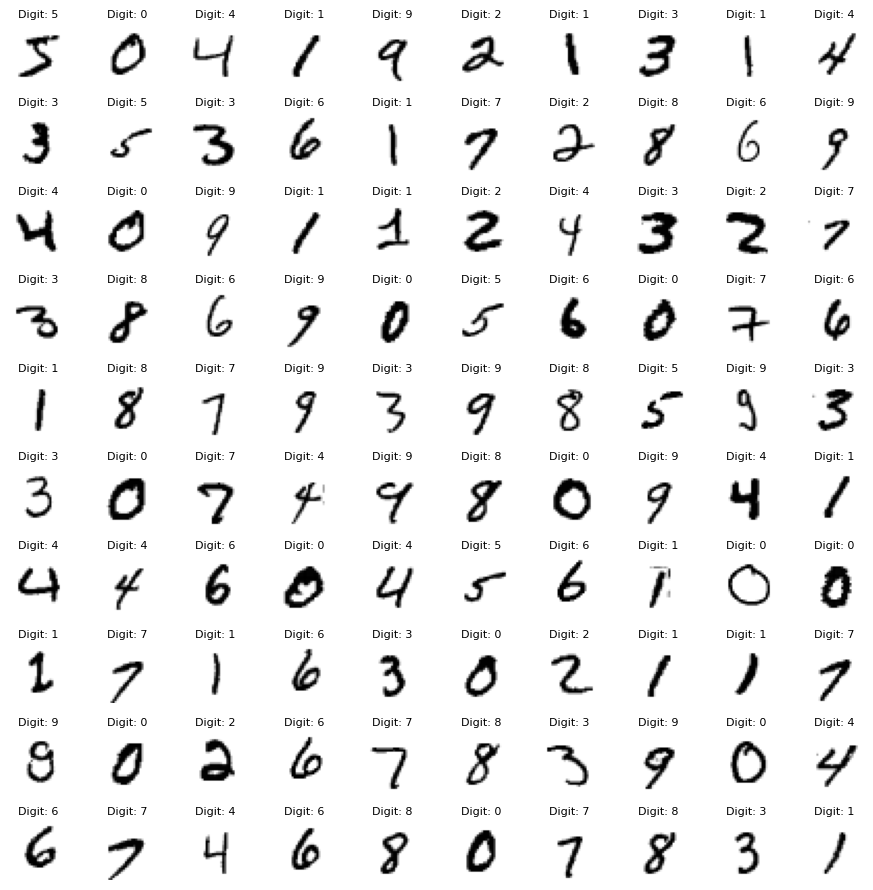

In [119]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(pixels[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data,label[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

### Count Plot

The number of images count in each class is displayed using a count plot. From the count plot, it is clear that each class has **unequal number of images**. The **digit 1** has **maximum number of images - 7877** and **digit 5** has the **least number of images - 6313**

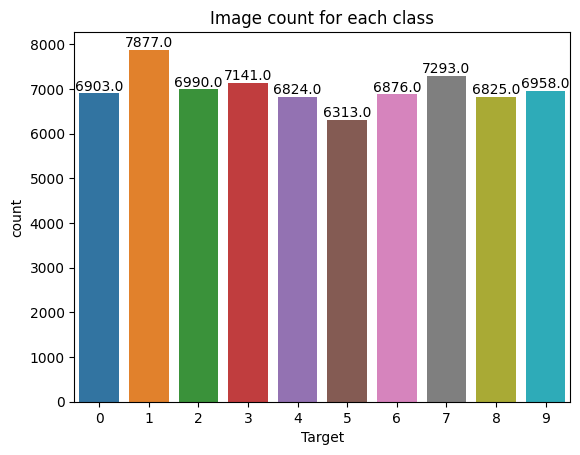

In [120]:
sns.countplot(df_mnist_dataset,x = "Target")
plt.title('Image count for each class')
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

### Pie Chart

The pie chart % of images in class in descending order. From the chart, we can find that the **digit class** 1 has the **highest percentage** of data **11.3%** followed by digit class 7 and digit class 3. **Digit 5** has the **least percentage of 9.02%**. The dataset is **balanced**

In [121]:
# Calculate the target distribution
Target_Dist_Total = df_mnist_dataset['Target'].value_counts(sort=False)

# Create a pie chart
fig = px.pie(Target_Dist_Total, values=Target_Dist_Total, names=Target_Dist_Total.index, hole=0.5)

# Update layout
fig.update_layout(
    title='Data Distribution of MNIST Dataset',
    font_size=15,
    title_x=0.45,
    annotations=[dict(text='MNIST Dataset', font_size=12, showarrow=False, x=0.5, y=0.5)]
)

# Update traces
fig.update_traces(textfont_size=15, textinfo='percent')

fig.show()

## Data Pre-Processing

Out of the 10 digits we are going to take **only 5 digits 0,2,4,6,8** and classify it using **SGDClassifier**. So, it a **Multiclass classification problem with 5 classes**

In [122]:
# Filtering the dataset containing only classes of digits 0,2,4,6 and 8
df_three_classes = df_mnist_dataset[df_mnist_dataset['Target'].isin(['0','2','4','6','8'])].reset_index()

In [123]:
# Printing the shape of the data frame
display(df_three_classes)

,index,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Target
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34413,69991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8
34414,69993,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34415,69995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
34416,69997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [124]:
# Checking the uniques values of Target
df_three_classes['Target'].unique()

['0', '4', '2', '6', '8']
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [125]:
# splitting it into input features and target variable
X = np.array(df_three_classes.iloc[:,0:784])
y = df_three_classes['Target']

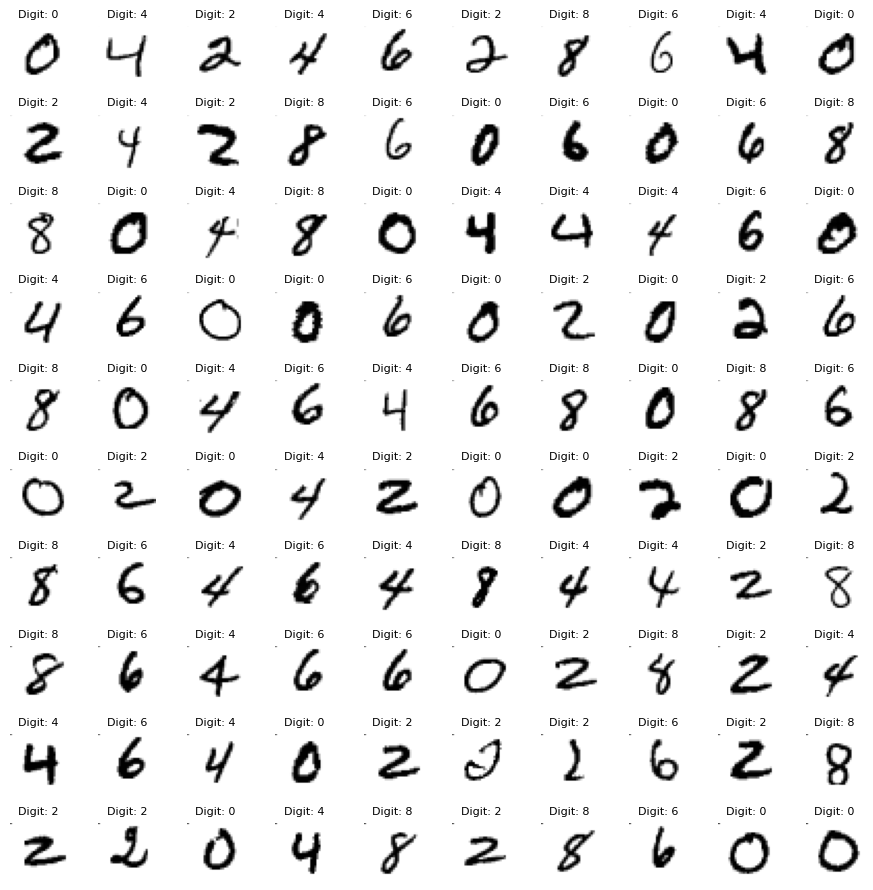

In [128]:
# Validating the first 100 images of filtered dataframe whether it contains only digits 0,2,4,6 and 8
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data,y[idx])
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout()
plt.show()

### Splitting the dataset into training (75%), validation (25%) and testing set (25%)

In [129]:
# Split the data into train and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

## Modeling

The decision to use SGDClassifier is inspired from a Kaggle notebook. The reference to the notebook is [MNIST_DIGIT RECOGNIZER](https://www.kaggle.com/code/amirdhavarshinis/mnist-digit-recognizer)

In [130]:
# Defining the SGDClassifier model
sgd_clf = SGDClassifier(random_state=42)
# Training the SGDClassifier with training dataset
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

## Model Evaluation

### Evaluation on validation set

The model is evaluated on the validation set.

In [131]:
# Model prediction on the validation set
y_val_pred = sgd_clf.predict(X_val)

### Confusion matrix

From the confusion matrix we can infer that the model **predicted the digits 0 and 4 accurately** when compared to other digits. 
* Out of **1037 digits which are 4**, the model **predicted 1026 images correctly as 4**. 
* Similarly **out of 1050 images which are 0** in the validation set, the **model predicted 1039 correctly**.
* The model **struggles in recognizing the digit 6**. It could **only identify 678 images correctly out of 985 images**

In [132]:
# Confusion matrix
cm = confusion_matrix(y_val,y_val_pred)
print(cm)

[[1039    2    5    2    2]
 [  45  916   64    4   44]
 [   1    3 1026    2    5]
 [  73    9  195  678   30]
 [  37   10  105    2  864]]


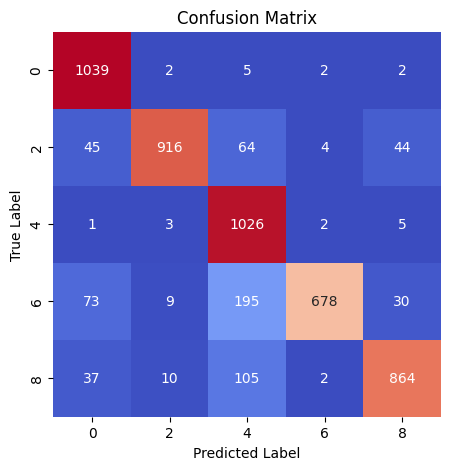

In [188]:
# plotting confusion matrix as a heat map
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['0','2','4','6','8'], yticklabels=['0','2','4','6','8'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Calculating precision, recall, F1 score for each class

Here we are using the function **precision_recall_fscore_support** available in **sklearn.metrics**. It will return a numpy array of precision,recall, F1 score, support for each class by **specifying the average parameter None**. We don't need support metric so, we can leave it. 
* From F1 score of each class, we can infer that model recognized digit 0 more accurately. Followed by digit 2 and 8. 
* The model struggles in recognizing the digit 6. 
* The **False positives of Class 4 is high** when compared to other class. so, the **precision of Class 4 is 73.5% which is less** when compared to other classes. 
* **Class 6 has more False negatives** which implies that the **model is not able to classify digit 6 and has a low recall of 68%**

In [189]:
# calculating precision, recall and f1score
precision,recall,f1score,_ = precision_recall_fscore_support(y_val,y_val_pred, average=None,labels=['0','2','4','6','8'])

In [190]:
# initializing a list as empty
val_results = []

In [192]:
# For each class appending the precision, recall, f1 score to a list 
for index,label in enumerate(['0','2','4','6','8']):
    val_results.append([label,precision[index],recall[index],f1score[index]])


In [166]:
df_val_results = pd.DataFrame(val_results,columns=['Class','Precision','Recall','F1 Score'])
display(df_val_results)

,Class,Precision,Recall,F1 Score
0,0,0.869456,0.989524,0.925612
1,2,0.974468,0.853681,0.910084
2,4,0.735484,0.989392,0.843750
3,6,0.985465,0.688325,0.810520
4,8,0.914286,0.848723,0.880285


### Overall metrics on validation set

The overall **accuracy of the model is 87.6%** on the validation set

In [167]:
# calculating the Overall accuracy, precision, recall and F1 score on validation set
overall_metric = [["SGD Classifier",accuracy_score(y_val,y_val_pred),precision_score(y_val,y_val_pred,average='weighted'),recall_score(y_val,y_val_pred,average='weighted'),f1_score(y_val,y_val_pred,average='weighted')]]

In [168]:
df_overall_val_results = pd.DataFrame(overall_metric,columns=['Model','Accuracy','Precision','Recall','F1 Score'])
display(df_overall_val_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,SGD Classifier,0.876041,0.895343,0.876041,0.875048


### Precision Recall Curve for chosen positive class - Digit 6

In [193]:
# calculated the decisin scores on validation set
y_val_scores = sgd_clf.decision_function(X_val)

In [194]:
# Choose one digit class 6
positive_class = '6'
binary_labels = []

In [195]:
# Converting it as binary labels 6 and Not 6
for class_label in y_val:
    if class_label == positive_class:
        binary_labels.append(1)
    else:
        binary_labels.append(0)

In [196]:
# converting list of labels into array
y_val_6 = np.array(binary_labels)

In [197]:
# Finding the index of positive class 6
positive_class_index = list(sgd_clf.classes_).index(positive_class)

In [203]:
# Taking only the decisin scores of 6
y_val_scores_6 = y_val_scores[:,positive_class_index]

In [204]:
# Calculating the precision, recall and threshold of Class 6
precisions, recalls, thresholds = precision_recall_curve(y_val_6, y_val_scores_6)

In [251]:
# setting the random threshold value
threshold = 5000000

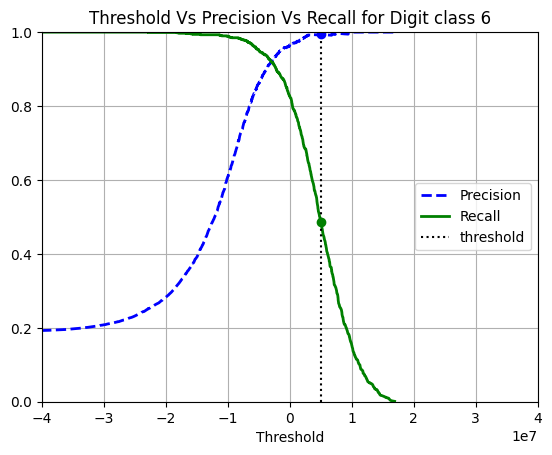

In [252]:
# plotting the precision recall curve along with Threshold. At Threshold 50000000 the precision is  1 and recall is 0.5
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-40000000, 40000000, 0, 1])
plt.title("Threshold Vs Precision Vs Recall for Digit class 6")
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

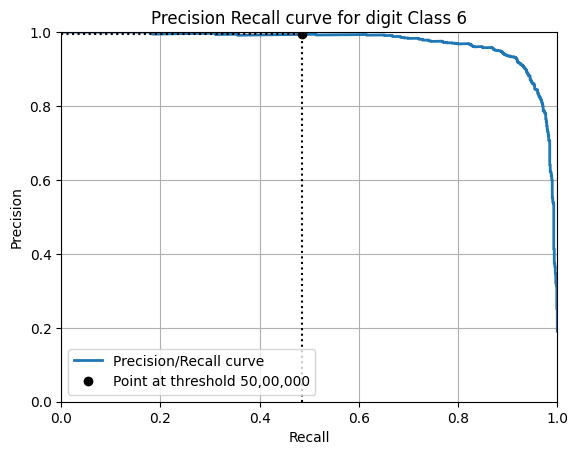

In [253]:
# Plotting precision recall curve for Digit 6
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 50,00,000")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for digit Class 6")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

### Increasing the recall for my chosen class 6 without retraining.

Actual **precision and recall** for **class 6 is 98.5% and 68.5% respectively**. To increase the recall, we have change the threshold value at which recall will be high. Here we want a recall of 90% or above. By changing the **threshold** to  **-3731352.91063837**, we can **increase the recall to 93.6%** but **the precision decrease to 90%**. The precision of my class is already high. I think the optimal threshold is -3731352.91063837.

In [281]:
# finding the threshold at which precision is 90%
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
print("Threshold value at which precision is 90% ", threshold_for_90_precision)

Threshold value at which precision is 90%  -3731352.91063837


In [282]:
# From the distance scores of class 6 returned by model, classifying the scores which are greater the custom threshold as positive
y_val_pred_90 = (y_val_scores_6 >= threshold_for_90_precision)

In [283]:
# Recalculating the recall score after applying custom threshold
recall_score_90 = recall_score(y_val_6,y_val_pred_90)
print(recall_score_90)

0.9360406091370559


In [284]:
# Recalculating the precision score after applying custom threshold
precision_score_90 = precision_score(y_val_6,y_val_pred_90)
print(precision_score_90)

0.900390625


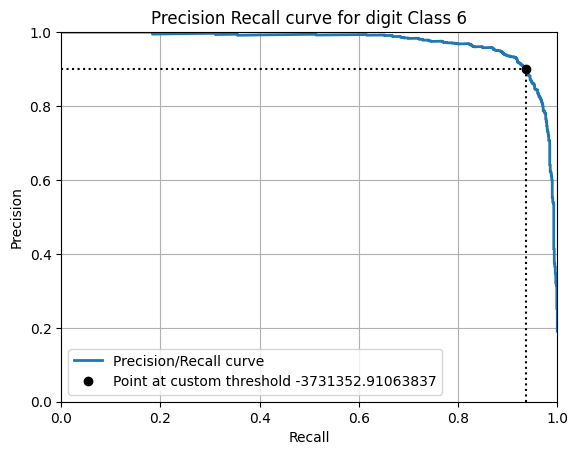

In [286]:
# Plotting precision recall curve for Digit 6 at custom threshold
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx_for_90_precision], recalls[idx_for_90_precision]], [0., precisions[idx_for_90_precision]], "k:")
plt.plot([0.0, recalls[idx_for_90_precision]], [precisions[idx_for_90_precision], precisions[idx_for_90_precision]], "k:")
plt.plot([recalls[idx_for_90_precision]], [precisions[idx_for_90_precision]], "ko",
         label="Point at custom threshold -3731352.91063837")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision Recall curve for digit Class 6")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

### Evaluation on test data

In [287]:
# Model prediction on the test set
y_test_pred = sgd_clf.predict(X_test)

In [288]:
# Confusion matrix
cm_test = confusion_matrix(y_test,y_test_pred)
print(cm_test)

[[ 992    0    3    0    3]
 [  31  869   55    4   46]
 [   7    3 1012    1    4]
 [  92    7  182  778   36]
 [  40   10  101    6  881]]


#### Confusion Matrix on test data

The model is able to classify only 778 images of digit 6 correctly out of 1095. 


In [299]:
y_test[y_test == '6'].count()

1095

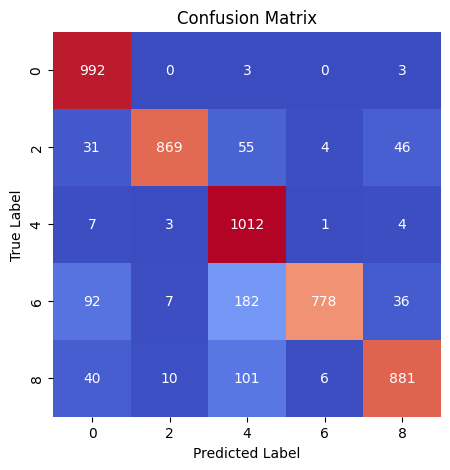

In [290]:
# plotting confusion matrix as a heat map
plt.figure(figsize=(5, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='coolwarm', cbar=False, xticklabels=['0','2','4','6','8'], yticklabels=['0','2','4','6','8'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Calculating precision, recall and f1score for each class on test data 

In [292]:
# calculating precision, recall and f1score
test_precision,test_recall,test_f1score,_ = precision_recall_fscore_support(y_test,y_test_pred, average=None,labels=['0','2','4','6','8'])

In [293]:
# initializing a list as empty
test_results = []

In [294]:
# For each class appending the precision, recall, f1 score to a list 
for index,label in enumerate(['0','2','4','6','8']):
    test_results.append([label,test_precision[index],test_recall[index],test_f1score[index]])

In [295]:
df_test_results = pd.DataFrame(test_results,columns=['Class','Precision','Recall','F1 Score'])
display(df_test_results)

,Class,Precision,Recall,F1 Score
0,0,0.853701,0.993988,0.918519
1,2,0.977503,0.864677,0.917635
2,4,0.747967,0.985394,0.850420
3,6,0.986058,0.710502,0.825902
4,8,0.908247,0.848748,0.877490


#### Overall Metric on test data

In [296]:
# calculating the Overall accuracy, precision, recall and F1 score on test set
test_overall_metric = [["SGD Classifier",accuracy_score(y_test,y_test_pred),precision_score(y_test,y_test_pred,average='weighted'),recall_score(y_test,y_test_pred,average='weighted'),f1_score(y_test,y_test_pred,average='weighted')]]

In [297]:
df_test_overall_val_results = pd.DataFrame(test_overall_metric,columns=['Model','Accuracy','Precision','Recall','F1 Score'])
display(df_test_overall_val_results)

,Model,Accuracy,Precision,Recall,F1 Score
0,SGD Classifier,0.877784,0.895805,0.877784,0.876909


## Conclusion

* The **accuracy of the model is 87.7%** which is **same for both validation and testing data**. This implies that model has learnt some pattern in classifying the digits.
* Also there is no such difference between overall precision and Recall value. F1 score is also good 87.6%.
* When considering the individual F1 score of each class, we can find that **the model struggles to classify digit 6 and 4**.
* Class 4 has more false positives and Class 6 has more false negatives.
* We can improve the performance of the model, by doing some preprocessing steps such as removing images of 4 and 6 which are already difficult to identify by humans.
* The model did **pretty well in classifying digit 2** with a **high precision of 97.7%**   